## Problem 1 [EM]
- Write a 2-dimensional RNG (random number generator) for a Gaussian mixture model (GMM) pdf with 2 sub-populations. Use any function/sub-routine available in your language of choice.

<IPython.core.display.Javascript object>


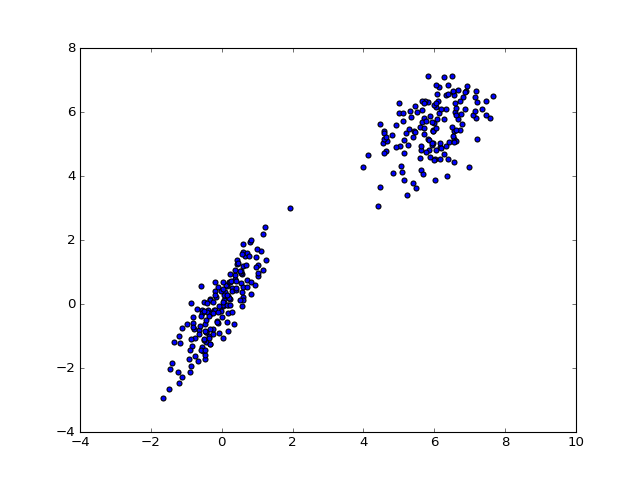

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

# Define the generator.
def twod2sprng(n, p, mean1, mean2, cov1, cov2):
    """
    This is a function for generating the 2-d RNG data with 2 sub-populations.
    n: number of points generated.
    p: the percent of population 1.
    mean1: the mean of the first sub-population.
    mean2: the mean of the second sub-population.
    cov1, cov2: the covarance of the first and second sub-population.
    """
    s = np.random.rand(n)
    # Generate the data for two populations
    x1, y1 = np.random.multivariate_normal(mean1, cov1, n).T
    x2, y2 = np.random.multivariate_normal(mean2, cov2, n).T
    x = (s < p)*x1 + (s >= p)*x2
    y = (s < p)*y1 + (s >= p)*y2
    return x,y

# Test the generator that we defined.
mean1 = (np.random.rand()+5,np.random.rand()+5)
mean2 = (np.random.rand(),np.random.rand())
cov1 = np.random.rand(2,2)
cov1 = np.dot(cov1,cov1.T)
cov2 = np.random.rand(2,2)
cov2 = np.dot(cov2,cov2.T)
N = 300
x, y = twod2sprng(N, 0.5, mean1, mean2, cov1, cov2)
# Visualize the data
plt.figure()
plt.scatter(x, y)
ax = plt.axes()
plt.show()

- Implement the expectation maximization (EM) algorithm for estimating the pdf parameters of 2-D GMMs from samples (Refer to the Noisy Clustering Paper linked on blackboard for the relevant update equations).
> $$
 \alpha (t+1) = \frac{1}{N}\sum_{i=1}^{N}p_z(j|y_i,\Theta (t))\\
 \mu (t+1) = \frac{\sum_{i=1}^{N} p_z(i|y_i, \Theta(t)) y_i}{\sum _{i=1}^{N} p_z (i|y_i, \Theta (t))}\\
 \Sigma _j (t+1) = \frac{\sum _{i=1}^{N} p_z (j|y_i,\Theta (t))(y_i - \mu _j(t)) (y_i - \mu _j (t))^T}{\sum _{i=1}^{N} p_z (j|y_i, \Theta (t))}
 $$

In [2]:
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
# Initialize the parameters, using k-mean
xy = np.array([x,y]).T
model = KMeans(n_clusters=2)
model.fit(xy)
mean1_t = model.cluster_centers_[0]
mean2_t = model.cluster_centers_[1]
cov1_t = np.ma.cov(xy.T)
cov2_t = cov1_t
p_t = np.random.rand()
# EM interation
MAXITERATION = 1000
tol = 0.001
theta = np.r_[p_t, mean1_t, mean2_t, cov1_t.reshape(-1),cov2_t.reshape(-1)]
iternum = -1
p_t_record = [p_t]
mean1_t_record = [mean1_t]
mean2_t_record = [mean2_t]
cov1_t_record = [cov1_t]
cov2_t_record = [cov2_t]
for i in range(MAXITERATION):
        # E-Step:
    w = np.array([p_t*multivariate_normal.pdf(xy, mean = mean1_t, cov = cov1_t),
                     (1-p_t)*multivariate_normal.pdf(xy, mean = mean2_t, cov = cov2_t)])
    w = w/sum(w,0)

        # M-Step:
    nml = sum(w.T)
    p_t = nml[0]/N
    mean1_t = np.r_[sum(w[0,:]*xy[:,0]), sum(w[0,:]*xy[:,1])]
    mean1_t = mean1_t/nml[0]
    mean2_t = np.r_[sum(w[1,:]*xy[:,0]), sum(w[1,:]*xy[:,1])]
    mean2_t = mean2_t/nml[1]
    c1 = np.array([w[0],w[0]]).T*(xy-mean1_t)
    c2 = np.array([w[1],w[1]]).T*(xy-mean2_t)
    cov1_t = np.dot(c1.T,xy-mean1_t)/nml[0]
    cov2_t = np.dot(c2.T,xy-mean2_t)/nml[1]
    theta_t = np.r_[p_t, mean1_t, mean2_t, cov1_t.reshape(-1),cov2_t.reshape(-1)]
    diff = sum(abs(theta_t - theta))
    theta = theta_t
    p_t_record.append(p_t)
    mean1_t_record.append(mean1_t)
    mean2_t_record.append(mean2_t)
    cov1_t_record.append(cov1_t)
    cov2_t_record.append(cov2_t)
    if diff < tol:
        iternum = i
        break
 
print 'iteration times:',i

iteration times: 7


<IPython.core.display.Javascript object>


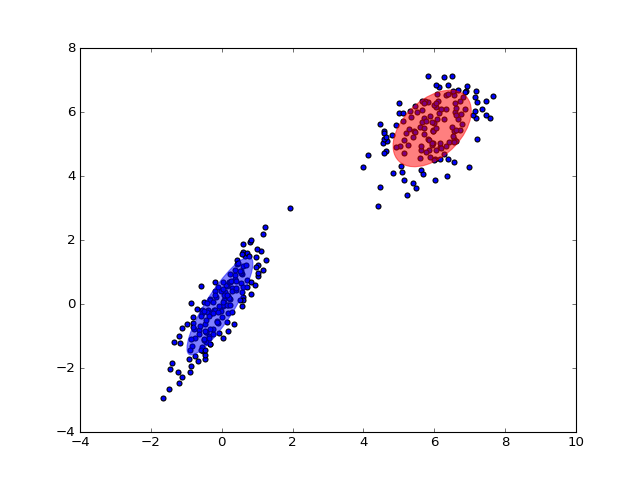

In [3]:
# Visualization of the process.
import matplotlib as mpl

if iternum < 4:
    index = np.r_[0:iternum-1]
else:
    index = np.linspace(0,iternum-1,4)
    
index = index.astype(int)
    
def add_ell_rst(mean1_t, mean2_t, cov1_t, cov2_t,ax):
    eig_vals, eig_vecs = np.linalg.eigh(cov1_t)
    unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
    angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
    angle = 180 * angle / np.pi
    eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
    ell1 = mpl.patches.Ellipse(mean1_t, eig_vals[0], eig_vals[1],
                                      180 + angle, color = 'r')

    eig_vals, eig_vecs = np.linalg.eigh(cov2_t)
    unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
    angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
    angle = 180 * angle / np.pi
    eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
    ell2 = mpl.patches.Ellipse(mean2_t, eig_vals[0], eig_vals[1],
                                      180 + angle, color = 'b')
    ell1.set_clip_box(ax.bbox)
    ell1.set_alpha(0.5)
    ell2.set_clip_box(ax.bbox)
    ell2.set_alpha(0.5)
    ax.add_artist(ell1)
    ax.add_artist(ell2)
    
plt.figure()
plt.scatter(x,y)
ax = plt.axes()
add_ell_rst(mean1_t, mean2_t, cov1_t, cov2_t,ax)
plt.show()

<IPython.core.display.Javascript object>


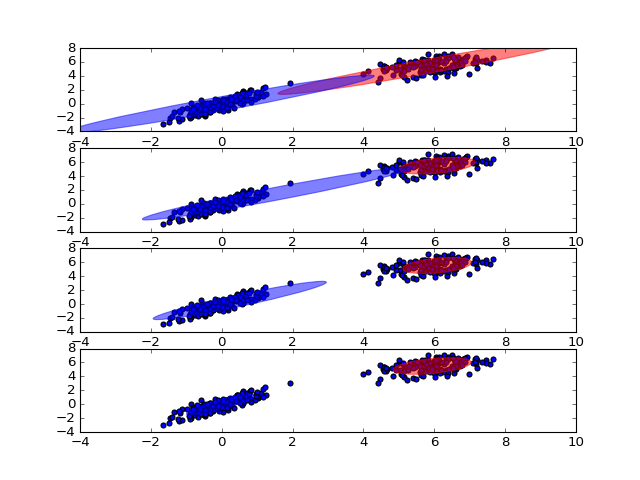

In [4]:
plt.figure()
for i in range(1,len(index)+1):
    ax = plt.subplot(len(index),1,i)
    plt.scatter(x,y)
    add_ell_rst(mean1_t_record[index[i-1]], mean2_t_record[index[i-1]], cov1_t_record[index[i-1]], cov2_t_record[index[i-1]],ax)
plt.show()

- Compare the quality and speed your GMM-EM estimation on 300 samples of different GMM distributions (e.g. spherical vs ellipsoidal covariance, close vs well-separated subpopulations).

**spherical vs ellipsoidal covariance**

In [5]:
def my_em_2d2pgmm(xy):
    # Initialize the parameters.
    model = KMeans(n_clusters=2)
    model.fit(xy)
    mean1_t = model.cluster_centers_[0]
    mean2_t = model.cluster_centers_[1]
    cov1_t = np.ma.cov(xy.T)
    cov2_t = cov1_t
    p_t = np.random.rand()
    # EM interation
    MAXITERATION = 1000
    tol = 0.001
    theta = np.r_[p_t, mean1_t, mean2_t, cov1_t.reshape(-1),cov2_t.reshape(-1)]
    iternum = 1
    p_t_record = [p_t]
    mean1_t_record = [mean1_t]
    mean2_t_record = [mean2_t]
    cov1_t_record = [cov1_t]
    cov2_t_record = [cov2_t]
    for i in range(MAXITERATION):
            # E-Step:
        w = np.array([p_t*multivariate_normal.pdf(xy, mean = mean1_t, cov = cov1_t),
                    (1-p_t)*multivariate_normal.pdf(xy, mean = mean2_t, cov = cov2_t)])
        w = w/sum(w,0)
            # M-Step:
        nml = sum(w.T)
        p_t = nml[0]/N
        mean1_t = np.r_[sum(w[0,:]*xy[:,0]), sum(w[0,:]*xy[:,1])]
        mean1_t = mean1_t/nml[0]
        mean2_t = np.r_[sum(w[1,:]*xy[:,0]), sum(w[1,:]*xy[:,1])]
        mean2_t = mean2_t/nml[1]
        c1 = np.array([w[0],w[0]]).T*(xy-mean1_t)
        c2 = np.array([w[1],w[1]]).T*(xy-mean2_t)
        cov1_t = np.dot(c1.T,xy-mean1_t)/nml[0]
        cov2_t = np.dot(c2.T,xy-mean2_t)/nml[1]
        theta_t = np.r_[p_t, mean1_t, mean2_t, cov1_t.reshape(-1),cov2_t.reshape(-1)]
        diff = sum(abs(theta_t - theta))
        theta = theta_t
        p_t_record.append(p_t)
        mean1_t_record.append(mean1_t)
        mean2_t_record.append(mean2_t)
        cov1_t_record.append(cov1_t)
        cov2_t_record.append(cov2_t)
        if diff < tol:
            iternum = i+1
            break

    return iternum, p_t, mean1_t, mean2_t, cov1_t, cov2_t

Generate 300 spherical separated gmm samples

In [6]:
spherial_sample_list = []
for i in range(300):
    mean1 = (np.random.rand()+5,np.random.rand()+5)
    mean2 = (np.random.rand(),np.random.rand())
    cov1 = np.random.rand()*np.eye(2)
    cov2 = np.random.rand()*np.eye(2)
    N = 300
    x,y = twod2sprng(N, 0.5, mean1, mean2, cov1, cov2)
    xy = np.array([x,y]).T
    spherial_sample_list.append(xy)   

In [7]:
from ipywidgets import IntProgress
from IPython.display import display
p = IntProgress()
display(p)
p.value = 0
spherial_iternum_list = []
for i in range(300):
    p.description = 'Running'
    iternum_f, p_t, mean1_t_f, mean2_t_f, cov1_t_f, cov2_t_f = my_em_2d2pgmm(spherial_sample_list[i])
    spherial_iternum_list.append(iternum_f)
    p.value = (i+1)/3
p.description = 'Finished'

<IPython.core.display.Javascript object>


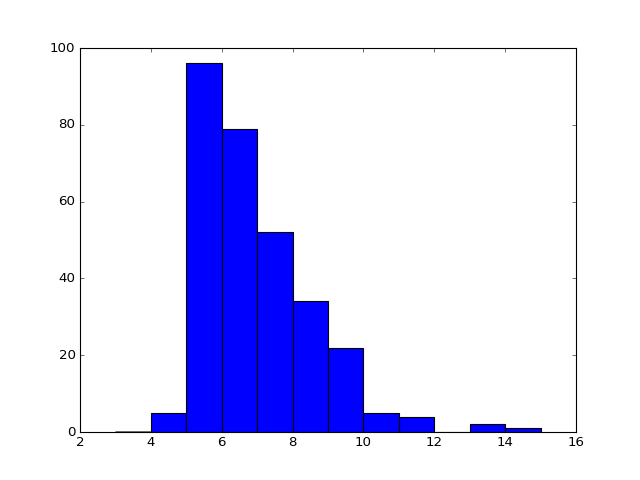

average iteration times: 6.47666666667


In [8]:
plt.figure()
plt.hist(spherial_iternum_list, bins=np.r_[min(spherial_iternum_list)-1:max(spherial_iternum_list)+1])
plt.show()
print 'average iteration times:', np.average(spherial_iternum_list)

Generate 300 ellipsoidal gmm samples

In [9]:
ellipsoidal_sample_list = []
for i in range(300):
    mean1 = (np.random.rand()+5,np.random.rand()+5)
    mean2 = (np.random.rand(),np.random.rand())
    
    cov1 = np.random.rand(2,2)
    cov1 = np.dot(cov1,cov1.T)
    eig_vals, eig_vecs = np.linalg.eigh(cov1)
    # Makes sure it is not spherial
    while(eig_vals[0]==eig_vals[1] or np.linalg.det(cov1)==0):
        cov1 = np.random.rand(2,2)
        cov1 = np.dot(cov1,cov1.T)
        eig_vals, eig_vecs = np.linalg.eigh(cov1)
    
    cov2 = np.random.rand(2,2)
    cov2 = np.dot(cov2,cov2.T)
    eig_vals, eig_vecs = np.linalg.eigh(cov2)
    # Makes sure it is not spherial
    while(eig_vals[0]==eig_vals[1] or np.linalg.det(cov2)==0):
        cov2 = np.random.rand(2,2)
        cov2 = np.dot(cov2,cov2.T)
        eig_vals, eig_vecs = np.linalg.eigh(cov2)
        
    N = 300
    x,y = twod2sprng(N, 0.5, mean1, mean2, cov1, cov2)
    xy = np.array([x,y]).T
    ellipsoidal_sample_list.append(xy)   

In [10]:
ellipsoidal_iternum_list = []
p.value = 0
display(p)
for i in range(300):
    iternum_f, p_t, mean1_t_f, mean2_t_f, cov1_t_f, cov2_t_f = my_em_2d2pgmm(ellipsoidal_sample_list[i])
    ellipsoidal_iternum_list.append(iternum_f)
    p.description = 'Running'
    p.value = (i+1)/3
p.description = 'Finished'    

<IPython.core.display.Javascript object>


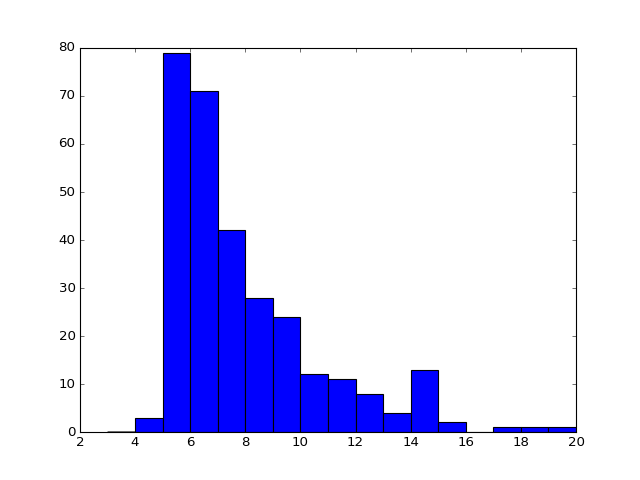

average iteration times: 7.41


In [11]:
plt.figure()
plt.hist(ellipsoidal_iternum_list, bins=np.r_[min(ellipsoidal_iternum_list)-1:max(ellipsoidal_iternum_list)+1])
plt.show()
print 'average iteration times:', np.average(ellipsoidal_iternum_list)

As we can see above, the average iteration times for spherical and ellipsoidal covariance are 6.5 and 7.4 respectively. Thus, the speed of my GMM-EM estimation on the spherical is a liitle faster than the ellipsoidal. 

**close vs well-separated subpopulations**

Generate 300 close gmm samples

In [12]:
close_sample_list = []
for i in range(300):
    mean1 = (np.random.rand(),np.random.rand())
    mean2 = (np.random.rand(),np.random.rand())
    cov1 = np.random.rand(2,2)
    cov1 = np.dot(cov1,cov1.T)
    # make sure the covariance matrix is non-singular
    while np.linalg.det(cov1) == 0:
        cov1 = np.random.rand(2,2)
        cov1 = np.dot(cov1,cov1.T)
    cov2 = np.random.rand(2,2)
    cov2 = np.dot(cov2,cov2.T)
    while np.linalg.det(cov2) == 0:
        cov2 = np.random.rand(2,2)
        cov2 = np.dot(cov2,cov2.T)
    N = 300
    x,y = twod2sprng(N, 0.5, mean1, mean2, cov1, cov2)
    xy = np.array([x,y]).T
    close_sample_list.append(xy)   

In [13]:
# Start EM GMM estimation on 300 samples.
p.value = 0
display(p)
close_iternum_list = []
for i in range(300):
    iternum_f, p_t, mean1_t_f, mean2_t_f, cov1_t_f, cov2_t_f = my_em_2d2pgmm(close_sample_list[i])
    close_iternum_list.append(iternum_f)
    p.description = 'Running'
    p.value = (i+1)/3
p.description = 'Finished'

<IPython.core.display.Javascript object>


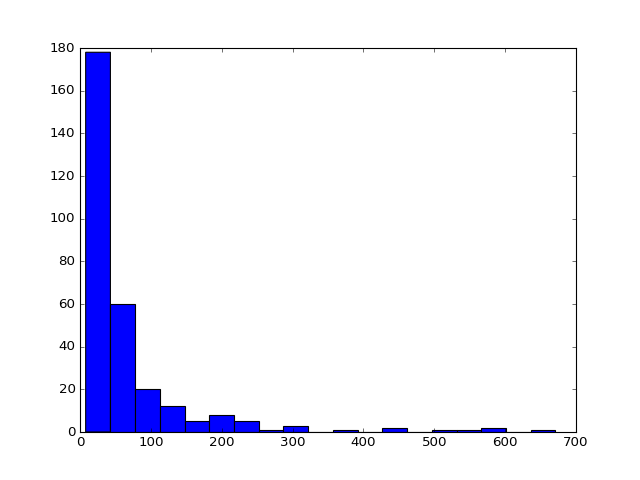

average iteration times: 66.6466666667


In [14]:
plt.figure()
plt.hist(close_iternum_list, bins=np.linspace(min(close_iternum_list)-1,max(close_iternum_list)+1,20))
plt.show()
print 'average iteration times:', np.average(close_iternum_list)

Generate 300 separated gmm samples

In [15]:
separated_sample_list = []
for i in range(300):
    mean1 = (np.random.rand()+5,np.random.rand()+5)
    mean2 = (np.random.rand(),np.random.rand())
    cov1 = np.random.rand(2,2)
    cov1 = np.dot(cov1,cov1.T)
    cov2 = np.random.rand(2,2)
    cov2 = np.dot(cov2,cov2.T)
    # make sure the covariance matrix is non-singular
    while np.linalg.det(cov1) == 0:
        cov1 = np.random.rand(2,2)
        cov1 = np.dot(cov1,cov1.T)
    cov2 = np.random.rand(2,2)
    cov2 = np.dot(cov2,cov2.T)
    while np.linalg.det(cov2) == 0:
        cov2 = np.random.rand(2,2)
        cov2 = np.dot(cov2,cov2.T)
    N = 300
    x,y = twod2sprng(N, 0.5, mean1, mean2, cov1, cov2)
    xy = np.array([x,y]).T
    separated_sample_list.append(xy)   

In [16]:
p.value = 0
display(p)
separated_iternum_list = []
for i in range(300):
    p.description = 'Running'
    p.value = (i+1)/3
    iternum_f, p_t, mean1_t_f, mean2_t_f, cov1_t_f, cov2_t_f = my_em_2d2pgmm(separated_sample_list[i])
    separated_iternum_list.append(iternum_f)
p.description = 'Finished'

<IPython.core.display.Javascript object>


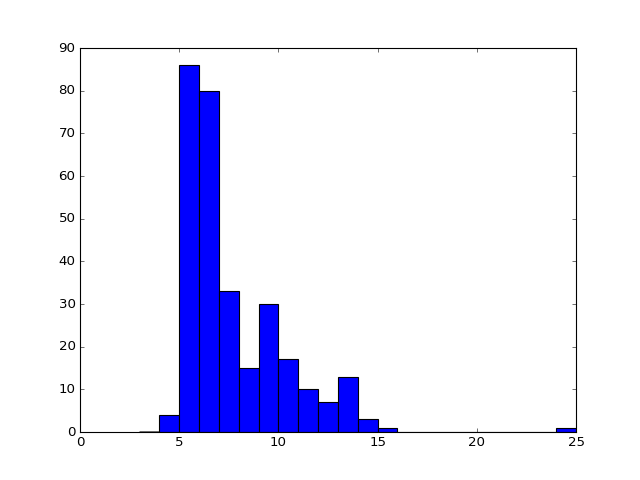

average iteration times: 7.20666666667


In [17]:
plt.figure()
plt.hist(separated_iternum_list, bins=np.r_[min(separated_iternum_list)-1:max(separated_iternum_list)+1])
plt.show()
print 'average iteration times:', np.average(separated_iternum_list)

The average iteration times for close and separated data are 60.6 and 7.2 respectively. Therefore, we conclude that my EM gmm estimation is much faster on separated data and close data. 